<a href="https://colab.research.google.com/github/luismartins26/segcomp/blob/main/Lista_de_Exerc%C3%ADcios_01_LE01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lista de Exercícios 01

CIC0201 - Segurança Computacional – 2025/1

Disciplina: Segurança Computacional

Professora: Lorena Borges

Estudante: Luís Martins (242037814)

# Introdução

O objetivo desse caderno é elaborar não só os códigos para realizar a cifra por deslocamento e transposição e a respectiva
decifração, mas também os códigos que quebram essas cifras, através de duas estratégias de ataques à cifra (CipherText-only), a dizer,
ataque de força bruta e distribuição de frequência. Além disso, almejo descrever a viabilidade das estratégias, comparar a complexidade dos algoritmos e
tempo de execução, onde cada técnica seria melhor aplicada etc.


Além da presente introdução, o caderno apresenta seções de Definições, Cifra por deslocamento, Cifra por transposição e Conclusão. Começo por delinear o arcabouço comuns às duas cifras, para, em seguida, implementar os algoritmos e análises individuais. As seções não devem ser tomadas individualmente, pois há considerações acerca da cifra por deslocamento que são aproveitadas na cifra por transposição. A conclusão encerra o caderno com uma síntese do que foi trabalhado.

# Definições

## Inicialização de bibliotecas e classe base

In [2]:
from abc import ABC, abstractmethod
import random
import math
from bs4 import BeautifulSoup
import requests

Em que pese a padronização do python para nomeação de parâmetros e métodos, sigo a definição utilizada na disciplina para a classe abstrata que guarda os principais métodos de criptografia. As cifras específicas são implementações particulares da classe abstrata.

In [3]:
class Cifra(ABC):
    @abstractmethod
    def Gen(self) -> any:
        pass

    def set_key(self, key):
        self.key = key

    @abstractmethod
    def Enc(self, M: str) -> str:
        pass

    @abstractmethod
    def Dec(self, C: str) -> str:
        pass

Mais precisamente, as definições são,

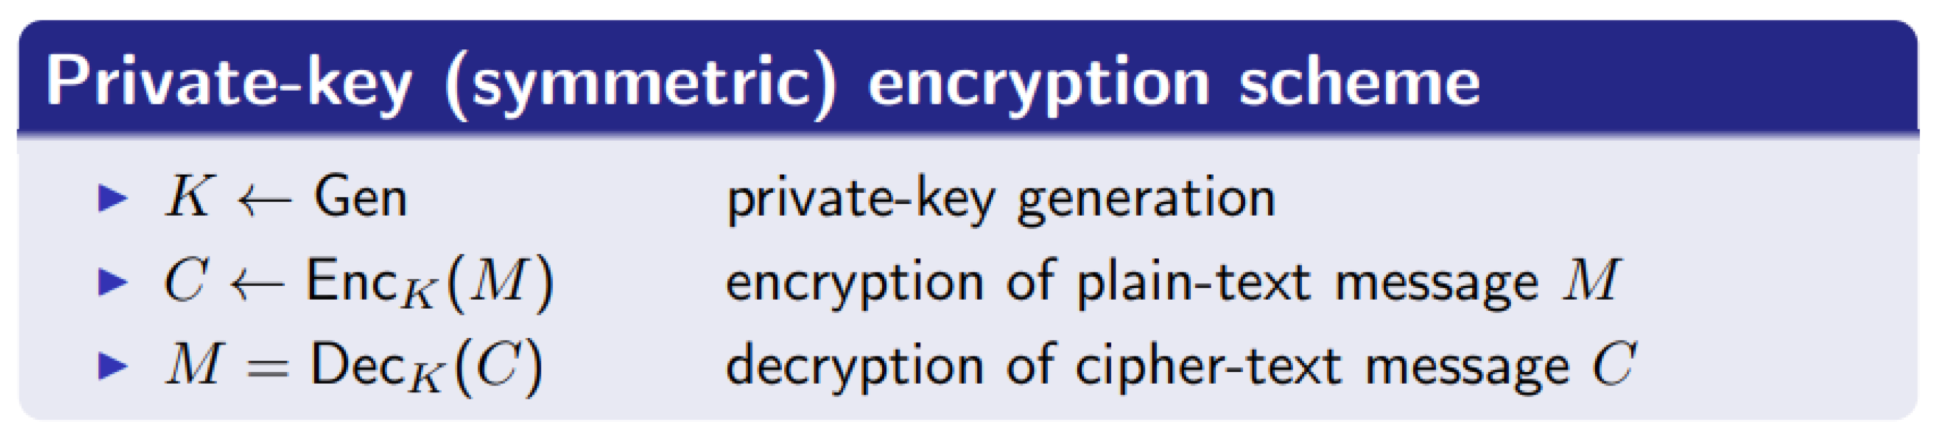

O método *set_key* foi adicionado para permitir a escolha de uma chave específica, ao invés de depender que o método *Gen* gere a chave específica desejada.

## Premissas sobre a mensagem

## Estatísticas

In [4]:
def extrair_estatisticas():
    response = requests.get("https://www.dcc.fc.up.pt/%7Ervr/naulas/tabelasPT/")

    soup = BeautifulSoup(response.content, "html.parser")

    tabelas = soup.find_all("table")
    tabelas_extraidas = []
    for tabela in tabelas:
      linhas = tabela.find_all("tr")
      tabela_extraida = []
      for l in linhas:
        cols = l.find_all(["td", "th"])
        dados = [col.text.strip() for col in cols]
        tabela_extraida.append(dados)
      tabelas_extraidas.append(tabela_extraida)

    tabela_frequecia_letras = tabelas_extraidas[0]
    tabela_frequencia_digrafos = tabelas_extraidas[1]
    tabela_frequencia_trigrafos = tabelas_extraidas[2]

    letras = [e for v in tabela_frequecia_letras[::2] for e in v]
    freqs = [e for v in tabela_frequecia_letras[1::2] for e in v]
    frequencia_letras = {letras[i]:float(freqs[i]) for i in range(len(letras))}

    trigrafos = [e for v in tabela_frequencia_trigrafos[::2] for e in v]
    freqs = [e for v in tabela_frequencia_trigrafos[1::2] for e in v]
    frequencia_trigrafos = {trigrafos[i]:float(freqs[i])/10_000 for i in range(len(trigrafos))}

    frequencia_digrafos = dict()
    for r in tabela_frequencia_digrafos[1:]:
        for i in range(1, len(r)-1):
            frequencia_digrafos[tabela_frequencia_digrafos[0][i]+r[0]] = float(r[i])/1_000

    # Extraído manualmente
    frequencia_vogais_consoantes = {'v':47.7/100,'c':52.3/100}

    return frequencia_letras, frequencia_trigrafos, frequencia_digrafos, frequencia_vogais_consoantes

frequencia_letras, frequencia_trigrafos, frequencia_digrafos, frequencia_vogais_consoantes = extrair_estatisticas()

## Dicionário

https://www.ime.usp.br/~pf/dicios/

In [5]:
def extrair_dicionario():
    response = requests.get("https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt", stream=True)

    palavras = set()
    for l in response.iter_lines(decode_unicode=True):
        if l:
            palavras.add(l.strip().lower())

    return palavras

dicionario_palavras = extrair_dicionario()

In [6]:
def verificar_mensagem(M):
    for p in M.split(' '):
        if p not in dicionario_palavras:
            return False
    return True

## Corpus de teste

In [87]:
# prompt: download all psalms from https://www.bibliaonline.com.br/acf/sl

import requests
from bs4 import BeautifulSoup

def download_psalms():
    base_url = "https://www.bibliaonline.com.br/acf/sl"
    all_psalms = []

    for i in range(1, 150+1):  # Psalms 1 to 150
        url = f"{base_url}/{i}"
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        soup = BeautifulSoup(response.content, "html.parser")
        psalm_text = [p.text.strip() for p in soup.find_all("span", class_="t")]
        all_psalms+=(psalm_text)

    return all_psalms


psalms = download_psalms()


In [88]:
# prompt: remove_accents_and_punctuation from the psalms. Hyphen should become blank space

import unicodedata
import re

def remove_accents_and_punctuation(text):
  text = ''.join(c for c in unicodedata.normalize('NFD', text)
                  if unicodedata.category(c) != 'Mn')
  text = re.sub(r'[^\w\s-]', '', text) # Remove punctuation except hyphens
  text = text.replace('-', ' ') # Replace hyphens with spaces
  return text.lower()

corpus = []
# Example usage with the downloaded psalms:
for i, psalm in enumerate(psalms):
    cleaned_psalm = remove_accents_and_punctuation(psalm)
    if(verificar_mensagem(cleaned_psalm)):
       corpus.append(cleaned_psalm)


# Cifra por Deslocamento

## Implementação

In [7]:
class CifraDeslocamento(Cifra):
    def __init__(self):
        self.alfabeto = 'abcdefghijklmnopqrstuvxywz'

    def Gen(self):
        return random.randint(0, len(self.alfabeto)-1)

    def Enc(self, M):
        C = ''
        for i in range(len(M)):
            faz_parte_alfabeto = False
            for j in range(len(self.alfabeto)):
                if M[i] == self.alfabeto[j]:
                    C += self.alfabeto[(j + self.key) % len(self.alfabeto)]
                    faz_parte_alfabeto = True
                    break
            if not faz_parte_alfabeto:
                C += M[i]
        return C

    def Dec(self, C):
        M = ''
        for i in range(len(C)):
            faz_parte_alfabeto = False
            for j in range(len(self.alfabeto)):
                if C[i] == self.alfabeto[j]:
                    M += self.alfabeto[(j - self.key) % len(self.alfabeto)]
                    faz_parte_alfabeto = True
                    break
            if not faz_parte_alfabeto:
                M += C[i]
        return M

## Teste

In [8]:
cifraCesar = CifraDeslocamento()
cifraCesar.set_key(3)
assert cifraCesar.Enc('luis') == 'oylv'
assert cifraCesar.Dec('oylv') == 'luis'

In [94]:
# prompt: pick a random single element of the corpus and Enc it

import random

# Assuming 'corpus' is defined as in the provided code
random_element = random.choice(corpus)

cifraCesar = CifraDeslocamento()
cifraCesar.set_key(3)  # Or any other key you want to use
encrypted_element = cifraCesar.Enc(random_element)

print(f"Original: {random_element}")
print(f"Encrypted: {encrypted_element}")


Original: justo es o senhor e retos sao os teus juizos
Encrypted: myvxr hv r vhqkru h uhxrv vdr rv xhyv mylcrv


## Análise de complexidade

$O (m n)$


## Ataque de força bruta

In [9]:
def ataque_forca_bruta(C):
  cifraDeslocamento = CifraDeslocamento()
  for i in range(len(cifraCesar.alfabeto)):
      cifraDeslocamento.set_key(i)
      M = cifraDeslocamento.Dec(C)
      if verificar_mensagem(M):
          return i, M
  raise Exception("Cifra não corresponde a mensagem válida.")


In [84]:
cifraDeslocamento = CifraDeslocamento()
k = cifraDeslocamento.Gen()
cifraDeslocamento.set_key(k)
M = random.choice(corpus)
C = cifraDeslocamento.Enc(M)
print(M)
print(k)
print(C)
ataque_forca_bruta(C)

o senhor reina regozije se a terra alegrem se as muitas ilhas
10
w coyrwb bosyk boqwjsto co k dobbk kvoqbox co kc xesdkc svrkc


(10, 'o senhor reina regozije se a terra alegrem se as muitas ilhas')

## Ataque por distribuição de frequência

https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Bayesian_updating


# Cifra por Transposição

In [ ]:
class CifraTransposicao(Cifra):
    def Gen(self, L:int):
        chave = list(range(L))
        random.shuffle(chave)
        return chave

    def Enc(self, M):
        C = [' ']*len(M)
        for i, k in enumerate(self.key):
            C[i] = M[k]
        return "".join(C)

    def Dec(self, C):
        chave_inversa = [item[1] for item in sorted(zip(self.key, range(len(self.key))))]
        chave_antiga = self.key
        self.key = chave_inversa
        M = self.Enc(C)
        self.key = chave_antiga
        return M


## Teste

In [ ]:
cifraTransposicao = CifraTransposicao()
chave = cifraTransposicao.Gen(4)
cifraTransposicao.set_key(chave)
assert cifraTransposicao.Dec(cifraTransposicao.Enc('luis')) == 'luis'

# Referências